In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import newton
from scipy.integrate import quad
from scipy.stats import norm
from numba import njit

# plot styling
plt.style.use('seaborn-darkgrid')
plt.rcParams['font.family'] = 'HP Simplified Jpan' # 'DIN Alternate'
plt.rcParams.update({'font.size': 13})
plt_dpi = None # change to 500

# Computer Assignment 3a
## ALM analysis

## 1. Explore the data

In [ ]:
# import SCB data
scb_xls = pd.ExcelFile('data/SCB_data_2016_2020.xlsx')

# read sheets separately
mean_pop_men_1620 = pd.read_excel(scb_xls, 'Mean_population_men', index_col='Age')
mean_pop_women_1620 = pd.read_excel(scb_xls, 'Mean_population_women', index_col='Age')
deaths_men_1620 = pd.read_excel(scb_xls, 'Deaths_men', index_col='Age')
deaths_women_1620 = pd.read_excel(scb_xls, 'Deaths_women', index_col='Age')

In [ ]:
# compute mean population between 2016 and 2020
mean_pop_men = mean_pop_men_1620.mean(axis=1).to_frame()
mean_pop_men.columns = ['Men']
mean_pop_women = mean_pop_women_1620.mean(axis=1).to_frame()
mean_pop_women.columns = ['Women']

# visualize
ax1 = mean_pop_men.plot(figsize=(8, 5))
mean_pop_women.plot(ax=ax1)

plt.legend(frameon=1, facecolor='white', framealpha=1, title='Gender')
plt.ylabel('Average Population')
plt.tight_layout()
plt.savefig('plots_CA3a/1a.png', dpi=plt_dpi, bbox_inches='tight')
plt.show()

In [ ]:
# compute mean deaths between 2016 and 2020 - men
deaths_men = deaths_men_1620.mean(axis=1).to_frame()
deaths_men.columns = ['Men']

# compute mean deaths between 2016 and 2020 - women
deaths_women = deaths_women_1620.mean(axis=1).to_frame()
deaths_women.columns = ['Women']

# visualize
ax1 = deaths_men.plot(figsize=(8, 5))
deaths_women.plot(ax=ax1)

plt.legend(frameon=1, facecolor='white', framealpha=1, title='Gender')
plt.ylabel('Average Number of Deaths')
plt.tight_layout()
plt.savefig('plots_CA3a/1b.png', dpi=plt_dpi, bbox_inches='tight')
plt.show()

## 2. Mortality estimation

a) Estimate the force of mortality for each gender.

In [ ]:
# estimate force of mortality - men
force_mortality_men = deaths_men.div(mean_pop_men)
force_mortality_men.columns = ['Men']

# estimate force of mortality - women
force_mortality_women = deaths_women.div(mean_pop_women)
force_mortality_women.columns = ['Women']

# visualize
ax1 = force_mortality_men.plot(figsize=(8, 5))
force_mortality_women.plot(ax=ax1)

plt.legend(frameon=1, facecolor='white', framealpha=1, title='Gender')
plt.ylabel('Force of Mortality')
plt.tight_layout()
plt.savefig('plots_CA3a/2a.png', dpi=plt_dpi, bbox_inches='tight')
plt.show()

b) Estimate the Makeham parameters.

In [ ]:
# the makeham function
def makeham(params, x):
    alpha, beta, gamma = params
    return alpha + beta * np.exp(gamma * x)

In [ ]:
def f1_fun(gamma, x):
    return np.sum(np.exp(gamma * x))

In [ ]:
def f2_fun(gamma, x):
    return np.sum(np.exp(2 * gamma * x))

In [ ]:
def g_fun(gamma, mu, x):
    return np.sum(mu * np.exp(gamma * x))

In [ ]:
# alpha expression
def a_fun(gamma, mu, x):
    m, N = np.sum(mu), x.shape[0]
    f1, f2 = f1_fun(gamma, x), f2_fun(gamma, x)
    g = g_fun(gamma, mu, x)
    nom = m * f2 - g * f1
    denom = N * f2 - np.square(f1)
    return nom / denom

In [ ]:
# beta expression
def b_fun(gamma, mu, x):
    m, N = np.sum(mu), x.shape[0]
    f1, f2 = f1_fun(gamma, x), f2_fun(gamma, x)
    g = g_fun(gamma, mu, x)

    nom = m * f1 - N * g
    denom = np.square(f1) - N * f2
    
    return nom / denom

In [ ]:
# derivative of makeham least squares expression w.r.t. gamma - eq. 3
def gamma_fun(gamma, mu, x):
    a, b = a_fun(gamma, mu, x), b_fun(gamma, mu, x)
    val = (a + b * np.exp(gamma * x) - mu) * x * b * np.exp(gamma * x)
    return np.sum(val)

In [ ]:
# derivative of makeham least squares expression w.r.t. alpha - eq. 1
def ab_fun(params, mu, x, gamma):
    a, b = params
    return np.sum(a + b * np.exp(gamma * x) - mu)

In [ ]:
def gamma_optimizer_nrm(mu, x):
    init_gamma = .101314
    gamma = newton(
        func=gamma_fun,
        x0=init_gamma,
        args=(mu, x)
    )
    return gamma

In [ ]:
def ab_optimizer_nrm(mu, x, gamma):
    init_ab = (.001, .000012)
    alpha, beta = newton(
        func=ab_fun,
        x0=init_ab,
        args=(mu, x, gamma)
    )
    return alpha, beta

In [ ]:
# optimizes alpha, beta given gamma
def makeham_optimizer_alt(mu, x):
    gamma = gamma_optimizer_nrm(mu, x)
    alpha, beta = ab_optimizer_nrm(mu, x, gamma)
    print('Makeham params (alpha, beta, gammma):')
    print(alpha, beta, gamma)
    return alpha, beta, gamma

In [ ]:
# directly calculates alpha, beta given gamma
def makeham_optimizer(mu, x):
    gamma = gamma_optimizer_nrm(mu, x)
    alpha, beta = a_fun(gamma, mu, x), b_fun(gamma, mu, x)
    print('Makeham params (alpha, beta, gammma):')
    print(alpha, beta, gamma)
    return alpha, beta, gamma

In [ ]:
print('MEN')
# estimate makeham parameters for men
n = 90
x_men = np.arange(20, n + 1)
mu_men = force_mortality_men.loc[:n].values.flatten()
a_men, b_men, g_men = makeham_optimizer(mu_men, x_men)
makeham_params_men = (a_men, b_men, g_men)

In [ ]:
print('WOMEN')
# estimate makeham parameters for women
n = 90
x_women = np.arange(20, n + 1)
mu_women = force_mortality_women.loc[:n].values.flatten()
a_women, b_women, g_women = makeham_optimizer(mu_women, x_women)
makeham_params_women = (a_women, b_women, g_women)

In [ ]:
# create dict of makeham params
makeham_params_dict = {
    'men': makeham_params_men,
    'women': makeham_params_women
}

In [ ]:
# convert makeham params to df
makeham_params = pd.DataFrame(
    {
        'alpha': [a_men, a_women],
        'beta': [b_men, b_women],
        'gamma': [g_men, g_women]
    }, 
    index=['Men', 'Women']
)

# visualize makeham params
makeham_params

In [ ]:
# for report use - 2b)
cap = 'The Makeham parameters for each gender.'
print(makeham_params.to_latex(position='H', caption=cap, label='tab:2b_makeham_params'))

In [ ]:
# visualize Makeham functions along with the force of mortalities, for both genders
n = 99
x = np.arange(20, n + 1)
makeham_men = makeham(makeham_params_men, x)
makeham_women = makeham(makeham_params_women, x)
makeham_vis = pd.DataFrame(
    {
        'Age': x,
        'Force of mortality (Men)': force_mortality_men.values.flatten(),
        'Force of mortality (Women)': force_mortality_women.values.flatten(), 
        'Makeham function (Men)': makeham_men,
        'Makeham function (Women)': makeham_women
    },
    index=x
)
makeham_plt = makeham_vis.set_index('Age')
makeham_plt.plot(figsize=(8, 5))

plt.legend(frameon=1, facecolor='white', framealpha=1, title='Category')
plt.ylabel('Force of Mortality (Makeham Estimate)')
plt.tight_layout()
plt.savefig('plots_CA3a/2b.png', dpi=plt_dpi, bbox_inches='tight')
plt.show()

c) Plot survival functions for both genders between for ages 0 to 105.

In [ ]:
# survival function with makeham estimate
def survival(x, a, b, g):
    val = -a * x - (b / g) * (np.exp(g * x) - 1)
    return np.exp(val)

In [ ]:
# survival function visualization for both genders
n = 105
x = np.arange(n + 1)
survival_men = survival(x, a_men, b_men, g_men)
survival_women = survival(x, a_women, b_women, g_women)
survival_df = pd.DataFrame({"Age": x, "Men": survival_men, "Women": survival_women})
survival_plt = survival_df.set_index("Age")
survival_plt.plot(figsize=(8, 5))

plt.legend(frameon=1, facecolor="white", framealpha=1, title="Gender")
plt.ylabel("Survival Function Value")
plt.tight_layout()
plt.savefig("plots_CA3a/2c.png", dpi=plt_dpi, bbox_inches="tight")
plt.show()

d) Calculate lifetime expectancy based on the Makeham distribution.

In [ ]:
# compute the lifetime expectancy for each gender - numerical integration
life_exp_men = quad(survival, 0, np.inf, args=makeham_params_men)[0]
life_exp_women = quad(survival, 0, np.inf, args=makeham_params_women)[0]

In [ ]:
# visualize lifetime expectancy
life_exp_df = pd.DataFrame(
    {
        'Men': life_exp_men,
        'Women': life_exp_women
    },
    index=['Life Expectancy']
).T
life_exp_df

In [ ]:
# for report use - 2d)
cap = 'The lifetime expectancy, in years, based on the lifetime \
     distribution given by the Makeham function, for each gender.'
print(life_exp_df.round(3).to_latex(position='H', caption=cap, label='tab:2c_life_exp'))

## 3. The state model

In [ ]:
# compute probabilty for death, q, in month t
def get_q(t, x, makeham_params):
    a, b, g = makeham_params
    l1 = survival(x + t / 12, a, b, g)
    l2 = survival(x + (t - 1) / 12, a, b, g)
    return 1 - l1 / l2

In [ ]:
# retirement indicator function
def get_t_pp_po(t, x, retirement):
    return (x + t / 12) == retirement + 1 / 12

In [ ]:
# compute transition probabilities
def get_transitions(pop, t, x, makeham_params, s_m, retirement):
    q_t = get_q(t, x, makeham_params)
    t_pp_de = pop[t - 1, 0] * q_t
    t_po_de = pop[t - 1, 1] * q_t
    t_pp_tr = (pop[t - 1, 0] - t_pp_de) * s_m
    t_pp_po = (pop[t - 1, 0] - t_pp_de - t_pp_tr) * get_t_pp_po(t, x, retirement)
    return t_pp_de, t_po_de, t_pp_tr, t_pp_po

In [ ]:
def pop_projection(init_state, T, init_age, makeham_params, transfer_prob):
    pop = np.zeros((T + 1, 4))
    retirement = 65
    if init_state == 'pp':
        pop[0, 0] = 1
    elif init_state == 'po':
        pop[0, 1] = 1
    else:
        return print('Incorrect initial state')

    for t in np.arange(1, T + 1):
        t_pp_de, t_po_de, t_pp_tr, t_pp_po = get_transitions(
            pop, t, init_age, makeham_params, transfer_prob, retirement
        )
        pop[t, 0] = pop[t - 1, 0] - t_pp_de - t_pp_tr - t_pp_po # PP
        pop[t, 1] = pop[t - 1, 1] - t_po_de + t_pp_po # PO
        pop[t, 2] = pop[t - 1, 2] + t_pp_de + t_po_de # DE
        pop[t, 3] = pop[t - 1, 3] + t_pp_tr # TR
    return pop

In [ ]:
# intial params
T = 30 * 12 # months of simulation
retirement = 65 # retirement age
init_age = 60 # initial age of policyholder
m = 12
transfer_prob_yearly = 0.02 # yearly transfer rate
transfer_prob = 1 - np.power(1 - transfer_prob_yearly, 1 / m) # monthly transfer rate
init_state = 'pp'
gender = 'women'

In [ ]:
# compute population projection for T months ahead
pop_sim = pop_projection(
    init_state=init_state, 
    T=T,
    init_age=init_age,
    makeham_params=makeham_params_dict[gender], 
    transfer_prob=transfer_prob
)

In [ ]:
# convert to dataframe
pop_df = pd.DataFrame(
    {
        'Simulated Age': 60 + np.arange(T + 1) / 12,
        'PP': pop_sim[:, 0],
        'PO': pop_sim[:, 1],
        'DE': pop_sim[:, 2],
        'TR': pop_sim[:, 3]
    }
).set_index('Simulated Age')
pop_df

In [ ]:
# visualize population projection
pop_df.plot.area(stacked=True, figsize=(8, 5), alpha=.75, lw=0)

plt.ylabel('Proportion')
plt.legend(frameon=1, facecolor='white', framealpha=1, title='State')
plt.tight_layout()
plt.savefig('plots_CA3a/3.png', dpi=plt_dpi, bbox_inches='tight')
plt.show()

## 4. 1st order payout and reserve

### 4a) Calculate b

In [ ]:
def PV(params, makeham_params, flag='premium'):
    x, u, s, d_G = params
    a, b, g = makeham_params
    l_x = survival(x, a, b, g)
    if flag == 'premium':
        t = np.arange(1, 12 * u + 1)
        l_xt = survival(x + t / 12, a, b, g)
        r_intensity = np.exp(-d_G * t / 12)
        return np.sum((l_xt / l_x) * r_intensity)

    elif flag == 'payout':
        t = np.arange(12 * u + 1, 12 * (u + s) + 1)
        l_xt = survival(x + t / 12, a, b, g)
        r_intensity = np.exp(-d_G * t / 12)
        return np.sum((l_xt / l_x) * r_intensity)

In [ ]:
# initial params
G0 = 2000000 # 1st order reserve
P0 = 120000 # initial monthly premium

In [ ]:
# policyholder parameters
x = 60
z = 65
s = 120 - z
u = z - x
r_G = .02
d_G = np.log(1 + r_G)
params = x, u, s, d_G

In [ ]:
# compute b value
sum_PP = P0 * PV(params, makeham_params_women, flag='premium')
sum_PO = PV(params, makeham_params_women, flag='payout')
b = (12 * G0 + sum_PP) / sum_PO
print('Yearly payout amount (b): {:.2f}'.format(b))

### 4b) Plot the evolution of the reserve 30 years into the future.

In [ ]:
def get_risk_premium(risk_sum, t, init_age, makeham_params):
    q = get_q(t, init_age, makeham_params)
    return (q / (1 - q)) * risk_sum

In [ ]:
def get_G(params, makeham_params, horizon=30):
    G0, P0, b, d_G, z, x = params
    T = horizon * 12
    G, P, B = np.zeros(T + 1), np.zeros(T + 1), np.zeros(T + 1)
    retirement_idx = (z - x) * 12 + 1
    P[:retirement_idx] = P0 / 12
    B[retirement_idx:] = b / 12
    G[0] = G0
    for t in np.arange(1, T + 1):
        risk_premium = get_risk_premium(-G[t - 1], t, x, makeham_params)
        G[t] = G[t - 1] * np.exp(d_G / 12)  + P[t] - B[t] - risk_premium
    return G

In [ ]:
# compute and visualize the 1st order reserve for 30 simulated years
params = G0, P0, b, d_G, z, x
G_30 = get_G(params, makeham_params_women, horizon=30)
# first_order = pd.DataFrame((pop_df['PP'] + pop_df['PO']) * G_30)
pop_df['1st Order Reserve'] = G_30
first_order = pop_df['1st Order Reserve']
# first_order.columns = ['1st Order Reserve']
first_order.plot(figsize=(8, 5), color='green', lw=2)
plt.legend(frameon=1, facecolor='white', framealpha=1)
plt.ylabel('1st Order Reserve')
plt.tight_layout()
plt.savefig('plots_CA3a/4b.png', dpi=plt_dpi, bbox_inches='tight')
plt.show()

### 4c) Include a table with the value of the reserve for every 10 years.

In [ ]:
reserve_10 = pd.DataFrame(first_order[(first_order.index % 10) == 0])
reserve_10

In [ ]:
# for report use - 4c)
cap = 'The first order reserve every 10th year during the simulation period.'
print(reserve_10.loc[70:].to_latex(position='H', caption=cap, label='tab:4c_reserves'))

# Computer Assignment 3b
## ALM analysis

### 5. Build ALM model

In [3]:
@njit
def get_risk_premium(risk_sum, t, init_age, makeham_params):
    q = get_q(t, init_age, makeham_params)
    return (q / (1 - q)) * risk_sum

In [4]:
# retirement indicator function
@njit
def get_t_pp_po(t, x, retirement):
    return (x + t / 12) == retirement + 1 / 12

In [5]:
# compute probabilty for death, q, in month t
@njit
def get_q(t, x, makeham_params):
    a, b, g = makeham_params
    l1 = survival(x + t / 12, a, b, g)
    l2 = survival(x + (t - 1) / 12, a, b, g)
    return 1 - l1 / l2

In [6]:
# survival function with makeham estimate
@njit
def survival(x, a, b, g):
    val = -a * x - (b / g) * (np.exp(g * x) - 1)
    return np.exp(val)

In [7]:
# compute transition probabilities
@njit
def get_transitions(pop, t, x, makeham_params, s_m, retirement):
    q_t = get_q(t, x, makeham_params)
    t_pp_de = pop[t - 1, 0] * q_t
    t_po_de = pop[t - 1, 1] * q_t
    t_pp_tr = (pop[t - 1, 0] - t_pp_de) * s_m
    t_pp_po = (pop[t - 1, 0] - t_pp_de - t_pp_tr) * get_t_pp_po(t, x, retirement)
    return t_pp_de, t_po_de, t_pp_tr, t_pp_po

In [8]:
@njit
def get_next_P1(P2, v):
    return P2 * v

In [9]:
@njit
def get_next_P2(P1, net_cf):
    return P1 - net_cf * P1 / np.sum(P1)

In [10]:
@njit
def get_portfolio_return(P1, P2):
    return np.sum(P1) / np.sum(P2)

In [11]:
# compute probabilty for death, q, in month t
@njit
def get_survival(t, x, makeham_params):
    a, b, g = makeham_params
    l1 = survival((x + t) / 12, a, b, g)
    l2 = survival(x / 12, a, b, g)
    return l1 / l2

In [12]:
# compute monthly payout given retirement
@njit
def get_B(params, makeham_params):
    po_lim, init_age, V, t_m, d_p, b_G = params
    current_age = init_age * 12 + t_m
    s = po_lim * 12 - current_age
    t = np.arange(0, s + 1 / 12)
    df = np.exp(-d_p * t / 12)
    l = get_survival(t, current_age, makeham_params)
    B = V / np.dot(df, l)
    res = np.max(np.array([B, b_G]))
    return res

In [13]:
# NS helper functions
@njit
def f2(lbd, t):
    return (1 - np.exp(-lbd * t)) / (lbd * t)

@njit
def f3(lbd, t):
    return f2(lbd, t) - np.exp(-lbd * t)

In [14]:
# estimate NS parameters
@njit
def get_r(beta, lbd, t):
    b1, b2, b3 = beta
    return b1 + b2 * f2(lbd, t) + b3 * f3(lbd, t)

In [15]:
@njit
def discount_BE(BE, beta, lbd):
    t = np.arange(1, BE.shape[0] + 1)
    r = get_r(beta, lbd, t)
    r[r < -.1] = -.1 # lower bound for interest rate
    d_p = np.log(1 + r)
    df = np.exp(-d_p * t / 12)
    BE_discounted = np.dot(BE, df)
    duration = np.sum(t * BE * df) / BE_discounted
    return BE_discounted, duration / 12.

In [16]:
# compute Best Estimate - undiscounted
@njit
def get_BE(t, pop, params, makeham_params):
    init_age, transfer_prob, retirement, G, P, b_G = params
    _, _, t_pp_tr, _ = get_transitions(
        pop, t, init_age, makeham_params, transfer_prob, retirement
    )
    if t <= (retirement - init_age) * 12:
        return t_pp_tr * G - pop[t, 0] * P / 12
    else:
        return pop[t, 1] * b_G + t_pp_tr * G

In [17]:
@njit
def get_net_cf(t, pop, params, makeham_params):
    init_age, transfer_prob, retirement, V, G, P, po_lim, d_p, b_G = params
    _, _, t_pp_tr, _ = get_transitions(
            pop, t, init_age, makeham_params, transfer_prob, retirement
        )
    if t <= (retirement - init_age) * 12:
        # before retirment - premium paying
        return t_pp_tr * np.amax(np.array([G, V])) - pop[t, 0] * P / 12
    else:
        # after retirement - payout
        B_params = po_lim, init_age, V, t, d_p, b_G
        B = get_B(B_params, makeham_params)
        return pop[t, 1] * B + t_pp_tr * np.max(np.array([G, V]))

In [18]:
@njit
def get_V(t, params, makeham_params):
    init_age, retirement, V, P, P1, P2, po_lim, d_p, b_G = params
    risk_premium = get_risk_premium(-V, t, init_age, makeham_params)
    portfolio_return = get_portfolio_return(P1, P2)
    if t <= (retirement - init_age) * 12:
        # before retirement
        return P / 12 - risk_premium + V * portfolio_return
    else:
        # after retirement
        B_params = po_lim, init_age, V, t, d_p, b_G
        B = get_B(B_params, makeham_params)
        return V * portfolio_return - risk_premium - B

In [19]:
@njit
def get_assets(data, strategy):
    if strategy == 'BH(100/0)':
        # stocks only
        assets = data[:, :10]
        return assets
    elif strategy == 'BH(0/100)':
        # Y15 only
        assets = data[:, 12].copy()
        dim = assets.shape[0]
        return assets.reshape((dim, 1))
    elif strategy == 'BH(50/50)':
        # stocks and Y5
        assets = data[:, :11]
        return assets
    elif strategy == 'CM(50/50)-1':
        # stocks and Y5
        assets = data[:, :11]
        return assets
    elif strategy == 'CM(50/50)-2':
        # stocks, Y10 and Y20
        idx = np.append(np.arange(10), [11, 13])
        assets = data[:, idx]
        return assets
    elif strategy == 'CPPI(2)':
        # stocks, Y10 and Y20
        idx = np.append(np.arange(10), [11, 13])
        assets = data[:, idx]
        return assets
    elif strategy == 'CPPI(2)-DD':
        # stocks, Y5 and Y20
        idx = np.append(np.arange(10), [10, 13])
        assets = data[:, idx]
        return assets
    elif strategy == 'CM(50/50)-LS':
        # long straddle in MSFT
        # stocks, Y05 and calls/puts
        assets = data[:, :11]
        return assets
    elif strategy == 'CPPI(2)-DD-LS':
        # stocks, Y5 and Y20 + LONG STRADDLE
        idx = np.append(np.arange(10), [10, 13])
        assets = data[:, idx]
        return assets

In [20]:
@njit
def get_init_P2(V0, strategy, D, BE_0, d0):
    if strategy == 'BH(100/0)':
        P2 = np.ones(10) * (V0 / 10.)
        return P2
    elif strategy == 'BH(0/100)':
        P2 = np.array([V0])
        return P2
    elif strategy == 'BH(50/50)':
        P2 = np.ones(11) * (V0 / 20.)
        P2[-1] = (V0 / 2.)
        return P2
    elif strategy == 'CM(50/50)-1':
        P2 = np.ones(11) * (V0 / 20.)
        P2[-1] = (V0 / 2.)
        return P2
    elif strategy == 'CM(50/50)-2':
        P2 = np.ones(12) * (V0 / 20.)
        M1, M2 = 10., 20. # maturities
        p = (D - M2) / (M1 - M2) # constant duration
        P2[-2] = (V0 / 2.) * p # Y10
        P2[-1] = (V0 / 2.) * (1 - p) # Y20
        return P2
    elif strategy == 'CPPI(2)':
        m = 2
        C0 = V0 - BE_0
        P2 = np.ones(12) * (m * C0 / 10.)
        M1, M2 = 10., 20. # maturities
        p = (D - M2) / (M1 - M2) # constant duration
        BE_c = BE_0 - C0 # cushion adjusted
        P2[-2] = BE_c * p # Y10
        P2[-1] = BE_c * (1 - p) # Y20
        return P2
    elif strategy == 'CPPI(2)-DD':
        m = 2
        C0 = m * (V0 - BE_0)
        P2 = np.ones(12) * (C0 / 10.)
        M1, M2 = 5.0, 20.0 # maturities
        p = (d0 - M2) / (M1 - M2) # constant duration
        BE_c = V0 - C0 # cushion adjusted
        P2[-2] = BE_c * p # Y5
        P2[-1] = BE_c * (1 - p) # Y20
        return P2
    elif strategy == 'CM(50/50)-LS':
        V = V0 * .98 # allocate 2% on puts/calls
        P2 = np.ones(11) * (V / 20.)
        P2[-1] = V / 2.
        return P2
    elif strategy == 'CPPI(2)-DD-LS':
        # stocks, Y5 and Y20 + LONG STRADDLE
        m = 2
        V0 = V0 * .98 # allocate 2% on puts/calls
        C0 = m * (V0 - BE_0)
        P2 = np.ones(12) * (C0 / 10.)
        M1, M2 = 5.0, 20.0 # maturities
        p = (d0 - M2) / (M1 - M2) # constant duration
        BE_c = V0 - C0 # cushion adjusted
        P2[-2] = BE_c * p # Y5
        P2[-1] = BE_c * (1 - p) # Y20
        return P2

In [21]:
@njit
def rebalance_portfolio(strategy, D, BE_i, d_i, V):
    if strategy == 'CM(50/50)-1':
        P2 = np.ones(11) * (V / 20.0)
        P2[-1] = V / 2.0
        return P2
    elif strategy == 'CM(50/50)-2':
        P2 = np.ones(12) * (V / 20.0)
        M1, M2 = 10.0, 20.0  # maturities
        p = (D - M2) / (M1 - M2)  # constant duration
        P2[-2] = (V / 2.0) * p  # Y10
        P2[-1] = (V / 2.0) * (1 - p)  # Y20
        return P2
    elif strategy == 'CPPI(2)':
        m = 2
        C = m * (V - BE_i)
        P2 = np.ones(12) * (C / 10.0)
        M1, M2 = 10.0, 20.0  # maturities
        p = (D - M2) / (M1 - M2)  # constant duration
        BE_c = V - C
        P2[-2] = BE_c * p  # Y10
        P2[-1] = BE_c * (1 - p)  # Y20
        return P2
    elif strategy == 'CPPI(2)-DD':
        m = 2
        C = m * (V - BE_i)
        P2 = np.ones(12) * (C / 10.0)
        M1, M2 = 5.0, 20.0  # maturities
        p = (d_i - M2) / (M1 - M2)  # constant duration
        BE_c = V - C  # cushion adjusted
        P2[-2] = BE_c * p  # Y5
        P2[-1] = BE_c * (1 - p)  # Y20
        return P2
    # option strategies
    elif strategy == 'CM(50/50)-LS':
        # option
        P2 = np.ones(11) * (V / 20.0)
        P2[-1] = (V / 2.0)
        return P2
    elif strategy == 'CPPI(2)-DD-LS':
        # stocks, Y5 and Y20 + LONG STRADDLE
        m = 2
        C = m * (V - BE_i)
        P2 = np.ones(12) * (C / 10.0)
        M1, M2 = 5.0, 20.0  # maturities
        p = (d_i - M2) / (M1 - M2)  # constant duration
        BE_c = V - C  # cushion adjusted
        P2[-2] = BE_c * p  # Y5
        P2[-1] = BE_c * (1 - p)  # Y20
        return P2

In [22]:
@njit
def get_duration_constant(BE, d_p):
    # based on constant interest rate - 2%
    t = np.arange(1, BE.shape[0] + 1)
    df = np.exp(-d_p * t / 12.)
    BE_constant_discount = np.dot(BE, df)
    duration_constant = np.sum(t * BE * df) / BE_constant_discount
    return duration_constant / 12.

In [23]:
# P variant
@njit
def sim_ALM_gen(data, NS, pop, params, makeham_params, strategy, option_data, T=360):
    init_age, transfer_prob, retirement, V0, P, po_lim, d_p, b_G, lbd_NS = params
    G = pop[:, -1] # 1st order reserve
 
    # compute BE
    T_BE = ((120 - init_age) * 12) + 1
    BE = np.zeros(T_BE)
    for i in np.arange(1, T_BE + 1):
        BE_params = init_age, transfer_prob, retirement, G[i - 1], P, b_G
        BE[i - 1] = get_BE(i, pop, BE_params, makeham_params)

    # discount BE and compute duration simultaneously
    BE_discounted = np.zeros(T + 1)
    duration = np.zeros(T + 1)
    constant_duration = np.zeros(T + 1)
    for i in np.arange(T + 1):
        BE_i = BE[i:]
        BE_discounted[i], duration[i] = discount_BE(
            BE_i, NS[i], lbd_NS
        )  # varying interest rate - NS
        constant_duration[i] = get_duration_constant(
            BE_i, d_p
        )  # constant interest rate - 2%

    if strategy == 'CPPI(2)':
        D = np.mean(constant_duration)
    else:
        D = np.mean(duration)

    # init params
    assets = get_assets(data, strategy)
    P2 = get_init_P2(V0, strategy, D, BE_discounted[0], duration[0])
    v_mat = assets[1:] / assets[:-1]
    V = np.zeros(T + 1)
    V[0] = V0


    # option strategy params
    V_options = V0 * .02
    maturity_counter = 0
    option_proportion = .02
    portfolio = np.zeros(T + 1)
    portfolio[0] = V0
    V_payoff = np.zeros(T + 1)

    # simulate strategy
    for t in np.arange(1, T + 1):
        v = v_mat[t - 1]  # v(t) / v(t-1)
        P1 = get_next_P1(P2, v)

        # compute V - 2nd order reserve
        V_params = init_age, retirement, V[t - 1], P, P1, P2, po_lim, d_p, b_G
        V[t] = get_V(t, V_params, makeham_params)

        # compute net cash flow
        cf_params = (
            init_age,
            transfer_prob,
            retirement,
            V[t - 1],
            G[t - 1],
            P,
            po_lim,
            d_p,
            b_G,
        )
        net_cf = get_net_cf(t, pop, cf_params, makeham_params)

        # update P2 vector
        P2 = get_next_P2(P1, net_cf)
        P2_sum = np.sum(P2)

        # compute payoff LS
        if strategy[-2:] == 'LS':
            if t % 6 == 0:
                S, K, payoff = option_data[maturity_counter, 2:]
                if S > K:
                    call_price = option_data[maturity_counter, 0]
                    payoff_t = ((V_options * .5) / call_price) * payoff
                elif K < S:
                    put_price = option_data[maturity_counter, 1]
                    payoff_t = ((V_options * .5) / put_price) * payoff
                else:
                    payoff_t = 0.0

                V_payoff[t] = payoff_t # track payoff
                V[t] += payoff_t
                P2_sum = (P2_sum + payoff_t) # add option payoff
                V_options = P2_sum * option_proportion # reallocate option capital
                P2_sum = P2_sum - V_options # update portfolio
                maturity_counter += 1

        portfolio[t] = P2_sum # track portfolio
        
        # rebalance portfolio based on chosen strategy
        # don't rebalance if buy-and-hold
        if strategy[:2] != 'BH':
            P2 = rebalance_portfolio(
                strategy, D, BE_discounted[t], duration[t], P2_sum
            )
    return V, BE_discounted, portfolio, V_payoff

In [24]:
# V variant
@njit
def sim_ALM_gen_(data, NS, pop, params, makeham_params, strategy, option_data, T=360):
    init_age, transfer_prob, retirement, V0, P, po_lim, d_p, b_G, lbd_NS = params
    G = pop[:, -1] # 1st order reserve
 
    # compute BE
    T_BE = ((120 - init_age) * 12) + 1
    BE = np.zeros(T_BE)
    for i in np.arange(1, T_BE + 1):
        BE_params = init_age, transfer_prob, retirement, G[i - 1], P, b_G
        BE[i - 1] = get_BE(i, pop, BE_params, makeham_params)

    # discount BE and compute duration simultaneously
    BE_discounted = np.zeros(T + 1)
    duration = np.zeros(T + 1)
    constant_duration = np.zeros(T + 1)
    for i in np.arange(T + 1):
        BE_i = BE[i:]
        BE_discounted[i], duration[i] = discount_BE(
            BE_i, NS[i], lbd_NS
        )  # varying interest rate - NS
        constant_duration[i] = get_duration_constant(
            BE_i, d_p
        )  # constant interest rate - 2%

    if strategy == 'CPPI(2)':
        D = np.mean(constant_duration)
    else:
        D = np.mean(duration)

    # init params
    assets = get_assets(data, strategy)
    P2 = get_init_P2(V0, strategy, D, BE_discounted[0], duration[0])
    v_mat = assets[1:] / assets[:-1]
    V = np.zeros(T + 1)
    V[0] = V0


    # option strategy params
    V_options = V0 * .02
    maturity_counter = 0
    option_proportion = .02
    V_payoff = np.zeros(T + 1)

    # simulate strategy
    for t in np.arange(1, T + 1):
        v = v_mat[t - 1]  # v(t) / v(t-1)
        P1 = get_next_P1(P2, v)

        # compute V - 2nd order reserve
        V_params = init_age, retirement, V[t - 1], P, P1, P2, po_lim, d_p, b_G
        V[t] = get_V(t, V_params, makeham_params)

        # compute net cash flow
        cf_params = (
            init_age,
            transfer_prob,
            retirement,
            V[t - 1],
            G[t - 1],
            P,
            po_lim,
            d_p,
            b_G,
        )
        net_cf = get_net_cf(t, pop, cf_params, makeham_params)

        # update P2 vector
        P2 = get_next_P2(P1, net_cf)
        print('P2', np.sum(P2))
        print('V_t', V[t])

        # compute payoff LS
        if strategy[-2:] == 'LS':
            if t % 6 == 0:
                S, K, payoff = option_data[maturity_counter, 2:]
                if S > K:
                    call_price = option_data[maturity_counter, 0]
                    payoff_t = ((V_options * .5) / call_price) * payoff
                elif K < S:
                    put_price = option_data[maturity_counter, 1]
                    payoff_t = ((V_options * .5) / put_price) * payoff
                else:
                    payoff_t = 0.0
                V_payoff[t] = payoff_t
                V[t] = (V[t] + payoff_t) # add option payoff
                V_options = V[t] * option_proportion # reallocate option capital
                V[t] = V[t] - V_options # update portfolio
                maturity_counter += 1

        # rebalance portfolio based on chosen strategy
        # don't rebalance if buy-and-hold
        if strategy[:2] != 'BH':
            P2 = rebalance_portfolio(
                strategy, D, BE_discounted[t], duration[t], payoff_t, t, V[t]
            )
    return V, BE_discounted, V_payoff

In [29]:
def get_G(params, makeham_params, horizon=30):
    G0, P0, b, d_G, z, x = params
    T = horizon * 12
    G, P, B = np.zeros(T + 1), np.zeros(T + 1), np.zeros(T + 1)
    retirement_idx = (z - x) * 12 + 1
    P[:retirement_idx] = P0 / 12
    B[retirement_idx:] = b / 12
    G[0] = G0
    for t in np.arange(1, T + 1):
        risk_premium = get_risk_premium(-G[t - 1], t, x, makeham_params)
        G[t] = G[t - 1] * np.exp(d_G / 12)  + P[t] - B[t] - risk_premium
    return G

In [30]:
def pop_projection(init_state, T, init_age, makeham_params, transfer_prob):
    pop = np.zeros((T + 1, 4))
    retirement = 65
    if init_state == 'pp':
        pop[0, 0] = 1
    elif init_state == 'po':
        pop[0, 1] = 1
    else:
        return print('Incorrect initial state')

    for t in np.arange(1, T + 1):
        t_pp_de, t_po_de, t_pp_tr, t_pp_po = get_transitions(
            pop, t, init_age, makeham_params, transfer_prob, retirement
        )
        pop[t, 0] = pop[t - 1, 0] - t_pp_de - t_pp_tr - t_pp_po # PP
        pop[t, 1] = pop[t - 1, 1] - t_po_de + t_pp_po # PO
        pop[t, 2] = pop[t - 1, 2] + t_pp_de + t_po_de # DE
        pop[t, 3] = pop[t - 1, 3] + t_pp_tr # TR
    return pop

In [31]:
def get_pop(params, makeham_params, horizon):
    G0, P0, b, d_G, z, x, transfer_prob = params
    T = horizon * 12
    G_params = G0, P0, b, d_G, z, x
    G = get_G(G_params, makeham_params, horizon)
    pop_sim = pop_projection(
        init_state='pp', 
        T=T,
        init_age=x,
        makeham_params=makeham_params, 
        transfer_prob=transfer_prob
    )
    pop_df = pd.DataFrame(
        {
            'Simulated Age': 60 + np.arange(T + 1) / 12,
            'PP': pop_sim[:, 0],
            'PO': pop_sim[:, 1],
            'DE': pop_sim[:, 2],
            'TR': pop_sim[:, 3]
        }
    ).set_index('Simulated Age')
    pop_df['1st Order Reserve'] = G
    return pop_df

In [32]:
# intial params
T = 30 * 12 # months of simulation
retirement = 65 # retirement age
init_age = 60 # initial age of policyholder
m = 12.
transfer_prob_yearly = 0.02 # yearly transfer rate
transfer_prob = 1. - np.power(1. - transfer_prob_yearly, 1. / m) # monthly transfer rate

# policyholder parameters
makeham_params_women = (0.0008721896252326899, 5.46142985377206e-07, 0.13793619493148213)
b = 168506.25
G0 = 2_000_000 # 1st order reserve
P0 = 120_000 # initial monthly premium
x = 60 # initial age
z = 65 # retirement age
s = 120 - z # maximum payoyt horizon
u = z - x # time until retirement
r_G = .02 # prognosis rate (yearly)
d_G = np.log(1 + r_G) # contionuos compounded prognosis rate
pop_params = G0, P0, b, d_G, z, x, transfer_prob

In [33]:
pop_120 = get_pop(pop_params, makeham_params_women, horizon=60)
pop_120

,PP,PO,DE,TR,1st Order Reserve
Simulated Age,,,,,
60.000000,1.000000,0.000000e+00,0.000000,0.000000,2.000000e+06
60.083333,0.998066,0.000000e+00,0.000253,0.001682,2.013808e+06
60.166667,0.996133,0.000000e+00,0.000507,0.003360,2.027647e+06
60.250000,0.994202,0.000000e+00,0.000762,0.005035,2.041517e+06
60.333333,0.992273,0.000000e+00,0.001020,0.006707,2.055417e+06
...,...,...,...,...,...
119.666667,0.000000,3.856513e-26,0.903292,0.096708,-7.976838e+28
119.750000,0.000000,1.963600e-26,0.903292,0.096708,-1.567969e+29
119.833333,0.000000,9.920251e-27,0.903292,0.096708,-3.106206e+29


In [34]:
# read data
one_scenario = pd.read_csv('data/OneScenario.csv', index_col='Period')
data_one = one_scenario.drop(columns=['Unnamed: 0', 'Scenario'])

In [35]:
data_one.head()

,BA,CAT,KO,DIS,JPM,MMM,MSFT,PFE,WMT,XOM,5Y,10Y,15Y,20Y,30Y,b1,b2,b3
Period,,,,,,,,,,,,,,,,,,
0,320.792166,143.343781,53.780119,141.816898,134.511845,169.601209,155.001728,37.374192,117.680306,65.502295,100.000000,100.000000,100.000000,100.000000,100.000000,0.02,0.0,0.0
1,322.099113,143.927782,53.999226,142.394678,135.059863,170.292185,155.633224,37.526459,118.159750,65.769159,100.246627,100.246627,100.246627,100.246627,100.246627,0.02,0.0,0.0
2,323.411384,144.514161,54.219225,142.974811,135.610113,170.985977,156.267293,37.679346,118.641147,66.037111,100.493862,100.493862,100.493862,100.493862,100.493862,0.02,0.0,0.0
3,324.729002,145.102930,54.440121,143.557308,136.162606,171.682595,156.903945,37.832857,119.124506,66.306154,100.741707,100.741707,100.741707,100.741707,100.741707,0.02,0.0,0.0
4,326.051989,145.694097,54.661917,144.142179,136.717349,172.382051,157.543191,37.986992,119.609834,66.576294,100.990163,100.990163,100.990163,100.990163,100.990163,0.02,0.0,0.0


In [36]:
# ALM parameters
makeham_params_women = (0.0008721896252326899, 5.46142985377206e-07, 0.13793619493148213)
V0 = 2_600_000.0 # initial 2nd order reserve
P = 120_000.0 # yearly premium
retirement_age = 65 # retirement age in month
init_age = 60 # initial age of policyholder
transfer_prob_yearly = .02 # yearly transfer rate
transfer_prob = 1 - np.power(1 - transfer_prob_yearly, 1 / 12) # monthly transfer rate
payout_limit = 120
r_y = .02 # yearly prognosis rate
d_p = np.log(1 + r_y) # continuous compounding of prognosis rate
b_G = b / 12 # guaranteed payoff, if B(t) < b
lbd_NS = .7308 # Nielson-Siegel lambda (monthly)
NS = data_one.iloc[:, -3:].values # NS parameters

In [37]:
params = init_age, transfer_prob, retirement_age, V0, P, payout_limit, d_p, b_G, lbd_NS
V, BE, _, _ = sim_ALM_gen(
    data_one.values, NS, pop_120.values, params, makeham_params_women, strategy='BH(100/0)', option_data=np.zeros((3, 3)), T=360
)

In [38]:
# computed expected 1st and 2nd order reserves
E = (pop_120['PP'] + pop_120['PO']).values[:V.shape[0]]
V_E = V * E
G_E = pop_120['1st Order Reserve'].values[:V.shape[0]] * E
BOF = V_E - BE

In [39]:
# create df for plotting
items_df = pd.DataFrame({
    'Month': np.arange(361),
    'E[G]': G_E,
    'E[V]': V_E,
    'V': V,
    'BE': BE,
    'BOF': BOF
}).set_index('Month')

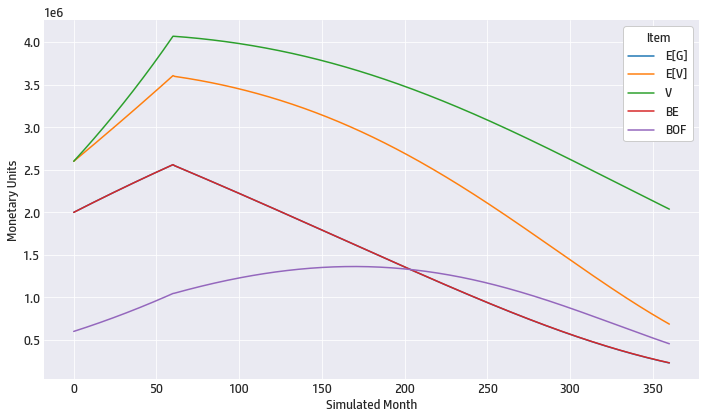

In [40]:
items_df.plot(figsize=(10, 6))
plt.legend(frameon=1, facecolor='white', framealpha=1, title='Item')
plt.ylabel('Monetary Units')
plt.xlabel('Simulated Month')
plt.tight_layout()
plt.savefig('plots_CA3b/5.png', dpi=plt_dpi, bbox_inches='tight')
plt.show()

In [41]:
items_5b = items_df.loc[[0, 60, 120]]

In [42]:
# for report use - 5b
cap = 'The 1st and 2nd reserve along with the value of the underlying assets, Best Estimate (BE) \
and Basic Own Funds (BOF), in month 0, 60 and 120, respectively.'
print(items_5b.to_latex(position='H', caption=cap, label='tab:5b_items'))

\begin{table}[H]
\centering
\caption{The 1st and 2nd reserve along with the value of the underlying assets, Best Estimate (BE) and Basic Own Funds (BOF), in month 0, 60 and 120, respectively.}
\label{tab:5b_items}
\begin{tabular}{lrrrrr}
\toprule
{} &          E[G] &          E[V] &             V &            BE &           BOF \\
Month &               &               &               &               &               \\
\midrule
0     &  2.000000e+06 &  2.600000e+06 &  2.600000e+06 &  1.999555e+06 &  6.004449e+05 \\
60    &  2.560459e+06 &  3.606870e+06 &  4.070085e+06 &  2.560525e+06 &  1.046344e+06 \\
120   &  2.051421e+06 &  3.345262e+06 &  3.916525e+06 &  2.051643e+06 &  1.293619e+06 \\
\bottomrule
\end{tabular}
\end{table}



### 6. Test investment strategies

In [43]:
@njit
def cnd(d):
    A1 = 0.31938153
    A2 = -0.356563782
    A3 = 1.781477937
    A4 = -1.821255978
    A5 = 1.330274429
    RSQRT2PI = 0.39894228040143267793994605993438
    K = 1.0 / (1.0 + 0.2316419 * np.abs(d))
    ret_val = (RSQRT2PI * np.exp(-0.5 * d * d) *
               (K * (A1 + K * (A2 + K * (A3 + K * (A4 + K * A5))))))
    return np.where(d > 0, 1.0 - ret_val, ret_val)

In [44]:
@njit
def black_scholes(stockPrice, optionStrike, optionYears, Riskfree, Volatility):
    S = stockPrice
    X = optionStrike
    T = optionYears
    R = Riskfree
    V = Volatility
    sqrtT = np.sqrt(T)
    d1 = (np.log(S / X) + (R + 0.5 * V * V) * T) / (V * sqrtT)
    d2 = d1 - V * sqrtT
    cndd1 = cnd(d1)
    cndd2 = cnd(d2)

    expRT = np.exp(- R * T)

    callResult = S * cndd1 - X * expRT * cndd2
    putResult = X * expRT * (1.0 - cndd2) - S * (1.0 - cndd1)

    return np.max(np.array([callResult, 0.01])), np.max(np.array([putResult, 0.01]))

In [45]:
def upper_tri_masking(A):
    """ Upper triangular without diagonal elements """
    m = A.shape[0]
    r = np.arange(m)
    mask = r[:, None] < r
    return A[mask]

In [46]:
def cov2cor(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

In [47]:
def mv_ewma_recursion(y, lbd, sigma):
    """
    Input: Log return y, lambda lbd and
           covariance matrix sigma.
    Output: Volatility forecast next day 
    """
    ret = (1 - lbd) * y.T @ y + lbd * sigma
    return ret

In [48]:
def ewma_recursion(y, lbd, sigma):
    """
    Input: Log return y, lambda lbd and
           covariance matrix sigma.
    Output: Volatility forecast next day 
    """
    ret = (1 - lbd) * np.square(y) + lbd * sigma
    return ret

In [49]:
def ewma(init_cov, lbd, Y, dim, n_assets):
    """
    Input: Initial covariance, log returns Y for n assets
           and the dimension. 
    Output: The covariance for the n assets during
            dim months.
    """
    sig = np.zeros((dim, n_assets))
    sig[0] = init_cov
    for i in np.arange(1, dim):
        y = Y[i - 1]
        if n_assets > 1:
            res = mv_ewma_recursion(y, lbd, sig[i - 1])
            sig[i] = upper_tri_masking(res)
        else:
            sig[i] = ewma_recursion(y, lbd, sig[i - 1])
    return np.sqrt(sig)

In [50]:
# generate ALM scenarios - balance sheet simulation 
def generate_scenarios(
    data_scen, pop, params, makeham_params, strategy, option_data, n_scenarios=2000, n_months=121
):
    V_mat, G_mat = np.zeros((n_scenarios, n_months)), np.zeros((n_scenarios, n_months))
    BE_mat, BOF_mat = np.zeros((n_scenarios, n_months)), np.zeros((n_scenarios, n_months))
    po_mat, portfolio = np.zeros((n_scenarios, n_months)), np.zeros((n_scenarios, n_months))
    assets = np.zeros((n_scenarios, n_months))
    E = (pop[:, 0] + pop[:, 1])[:n_months]
    G_E = pop[:n_months, -1] * E
    for s in np.arange(n_scenarios):
        data = data_scen[data_scen.Scenario == s + 1]
        NS_params = data.iloc[:, -3:].values
        sim_data = data.iloc[:, 2:-3].values
        options = option_data[s]
        V, BE, portfolio_s, payoff_s = sim_ALM_gen(
            sim_data, NS_params, pop, params, makeham_params, strategy, options, T=n_months-1
        )
        V_E = V * E
        BOF = V_E - BE
        V_mat[s], G_mat[s] = V_E, G_E
        BE_mat[s], BOF_mat[s] = BE, BOF
        portfolio[s] = portfolio_s
        assets[s] = V
        po_mat[s] = payoff_s # option payoff

    res = {
        'V': assets,
        'E[V]': V_mat,
        'E[G]': G_mat,
        'BE': BE_mat,
        'BOF': BOF_mat,
        'Portfolio': portfolio,
        'Payoff': po_mat
    }
    return res

In [51]:
def get_delta_BOF(BOF, quantile=5):
    yearly_BOF = BOF[:, 12]
    delta_BOF = yearly_BOF - BOF[:, 0]
    BOF_var = np.percentile(delta_BOF, q=quantile, axis=0)
    return yearly_BOF, delta_BOF, BOF_var

In [52]:
# read data
scenarios = pd.read_csv('data/ScenarioFile.csv')
data_scen = scenarios.drop(columns=['Unnamed: 0'])

In [53]:
data_scen.head()

,Scenario,Period,BA,CAT,KO,DIS,JPM,MMM,MSFT,PFE,WMT,XOM,Y05,Y10,Y15,Y20,Y30,b1,b2,b3
0,1,0,216.191063,177.803662,54.180673,188.928619,123.855865,169.727137,219.181528,35.159744,143.169719,39.716839,100.000000,100.000000,100.000000,100.000000,100.000000,0.021900,0.188112,-0.283152
1,1,1,223.031499,183.388667,54.807262,190.633176,120.778266,175.718032,235.215506,36.817413,126.197229,41.823050,99.718693,99.265869,98.948281,98.350537,95.640073,0.023508,0.216602,-0.318716
2,1,2,239.122498,229.922812,52.481603,199.669139,125.626846,168.990036,243.991493,36.101938,138.967343,42.963806,100.120569,100.398284,100.641394,100.418688,96.750479,0.023260,0.265108,-0.374475
3,1,3,215.245000,210.937407,52.844865,209.836597,137.181146,170.467802,233.218469,38.606766,149.574499,45.009583,100.268116,100.574060,100.677057,100.416835,97.687782,0.023090,0.250679,-0.358777
4,1,4,174.459243,187.442297,53.385205,201.224457,119.300384,160.572319,214.513367,37.410079,163.217767,43.318428,100.574698,101.227399,101.318576,100.984574,98.890871,0.022972,0.261942,-0.373095


In [54]:
# generate call and puts for microsoft with maturity 6m
@njit
def get_options(volatilites, stock_prices, n=2000):
    dim = 120
    maturity = .5
    r_f = .02
    T = np.arange(-1, dim + 1, 6)
    T[0] = 0
    res = np.zeros((n, T.shape[0] - 1, 5))
    for s in np.arange(n):
        volatility = volatilites[s].flatten()[:-1]
        stock_price = stock_prices[s].flatten()[:-1]
        for i in np.arange(T.shape[0]):
            # compute initial option price
            K = stock_price[T[i]]
            S = stock_price[T[i]]
            sigma = volatility[T[i]]

            # initial call and put prices
            res[s, i, 0], res[s, i, 1] = black_scholes(S, K, maturity, r_f, sigma)

            # compute payoffs
            S_maturity = stock_price[T[i + 1]]
            put_po = np.max(np.array([0., K - S_maturity]))
            call_po = np.max(np.array([0., S_maturity - K]))
            res[s, i, 2] = S_maturity # stock price at maturity
            res[s, i, 3] = K # strike price
            res[s, i, 4] = np.max(np.array([put_po, call_po])) # payoff
    return res

In [55]:
# MSFT STOCK

# extract microsoft stock
# stock_price_msft = data_scen['KO'].values.reshape((2000, 1, 121))
# msft = np.diff(np.log(stock_price_msft), axis=2)
# var_msft = np.var(msft, axis=2)

# # approximate implied volatility for microsoft
# lbd = .97
# dim = 121
# n = msft.shape[0]
# vol_msft = np.zeros((n, dim, 1))
# for i in np.arange(n):
#     vol_msft[i] = ewma(var_msft[i], lbd, msft[i].flatten(), dim, n_assets=1)

# msft_options = get_options(vol_msft, stock_price_msft)

In [56]:
# STOCK INDEX

# extract index stock
index_price = data_scen.loc[:, 'BA':'XOM'].mean(axis=1).values.reshape((2000, 1, 121))
index_return = np.diff(np.log(index_price), axis=2)
var_index = np.var(index_return, axis=2)

# approximate implied volatility for stock index
lbd = .97
dim = 121
n = index_return.shape[0]
vol_index = np.zeros((n, dim, 1))
for i in np.arange(n):
    vol_index[i] = ewma(var_index[i], lbd, index_return[i].flatten(), dim, n_assets=1)

# index options
index_options = get_options(vol_index, index_price)

In [57]:
# ALM parameters
V0 = 2_600_000. # initial 2nd order reserve
P = 120_000. # yearly premium
retirement_age = 65 # retirement age
init_age = 60 # initial age of policyholder
transfer_prob_yearly = .02 # yearly transfer rate
transfer_prob = 1. - np.power(1 - transfer_prob_yearly, 1. / 12.) # monthly transfer rate
payout_limit = 120
r_y = .02 # yearly prognosis rate
d_p = np.log(1 + r_y) # continuous compounding of prognosis rate
b_G = b / 12. # guaranteed payoff, if B(t) < b
lbd_NS = .7308 # Nielson-Siegel lambda

In [58]:
params_gen = init_age, transfer_prob, retirement_age, V0, P, payout_limit, d_p, b_G, lbd_NS
strategy = 'CPPI(2)-DD-LS'
option_data = index_options
n_scenarios = 2000
sim_strategy = generate_scenarios(
    data_scen, pop_120.values, params_gen,
    makeham_params_women, strategy=strategy,
    n_scenarios=n_scenarios,
    option_data=option_data
)

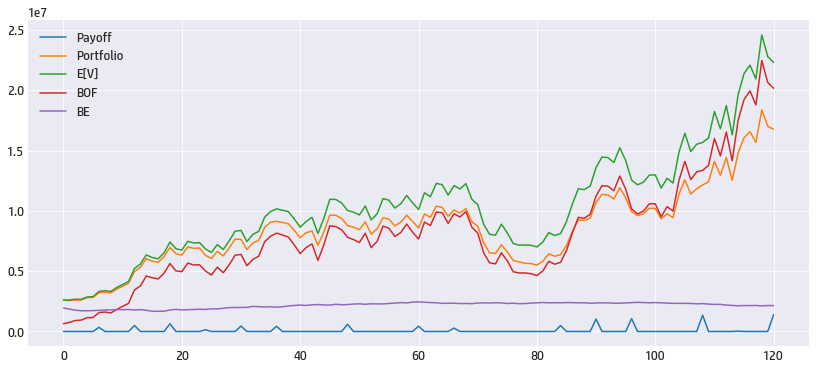

In [59]:
s = 1
plt.figure(figsize=(14, 6))
plt.plot(sim_strategy['Payoff'][s], label='Payoff')
plt.plot(sim_strategy['Portfolio'][s], label='Portfolio')
plt.plot(sim_strategy['E[V]'][s], label='E[V]')
plt.plot(sim_strategy['BOF'][s], label='BOF')
plt.plot(sim_strategy['BE'][s], label='BE')
plt.legend()
plt.show()

In [60]:
#pd.DataFrame(msft_options[s], columns=['C0', 'P0', 'S', 'K', 'payoff'])

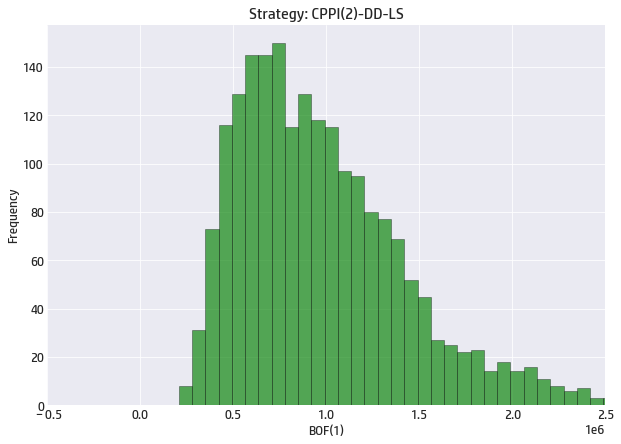

In [61]:
# compute delta BOF for 1 year
y_BOF, d_BOF, var_BOF = get_delta_BOF(sim_strategy['BOF'])

# visualize BOF(1) distribution for the strategy
plt.figure(figsize=(10, 7))
plt.hist(y_BOF, bins=50, color='green', alpha=.65, edgecolor='black', linewidth=.5)
plt.xlim([-500000, 2500000])
plt.title(f'Strategy: {strategy}')
plt.xlabel('BOF(1)')
plt.ylabel('Frequency')
plt.show()

In [62]:
print('Strategy:', strategy)
print('SCR:', var_BOF)

Strategy: CPPI(2)-DD-LS
SCR: -235229.18032103145


In [63]:
params_gen = init_age, transfer_prob, retirement_age, V0, P, payout_limit, d_p, b_G, lbd_NS
strategy_ = 'CPPI(2)-DD'
option_data = index_options
n_scenarios = 2000
sim_strategy_ = generate_scenarios(
    data_scen, pop_120.values, params_gen,
    makeham_params_women, strategy=strategy_,
    n_scenarios=n_scenarios,
    option_data=option_data
)

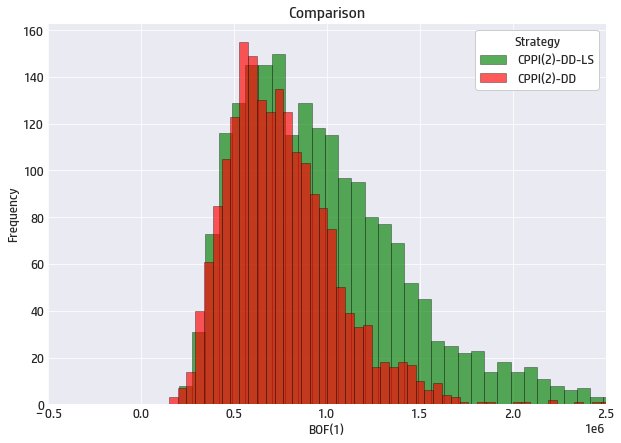

In [64]:
# compute delta BOF for 1 year
y_BOF_, d_BOF_, var_BOF_ = get_delta_BOF(sim_strategy_['BOF'])

# visualize BOF(1) distribution for the strategy
plt.figure(figsize=(10, 7))
plt.hist(y_BOF, bins=50, color='green', alpha=.65, edgecolor='black', linewidth=.5, label=strategy)
plt.hist(y_BOF_, bins=50, color='red', alpha=.65, edgecolor='black', linewidth=.5, label=strategy_)
plt.xlim([-500000, 2500000])
plt.title('Comparison')
plt.xlabel('BOF(1)')
plt.ylabel('Frequency')
plt.legend(frameon=1, facecolor='white', framealpha=1, title='Strategy')
plt.show()

In [65]:
print('Strategy:', strategy_)
print('SCR:', var_BOF_)

Strategy: CPPI(2)-DD
SCR: -272153.8681894542


In [66]:
def plot_sample(res, strategy, n_scenarios=2000, n_plots=5):
    samples = np.random.choice(n_scenarios, n_plots)
    for i in samples:
        plt.figure(figsize=(12, 4))
        plt.plot(res['E[V]'][i], label='E[V]')
        plt.plot(res['E[G]'][i], label='E[G]')
        plt.plot(res['BE'][i], label='BE')
        plt.plot(res['BOF'][i], label='BOF')
        plt.title(f'Strategy: {strategy}')
        plt.xlabel('Simulated Month')
        plt.legend(frameon=1, facecolor='white', framealpha=1, title='Item', loc=2)
        plt.tight_layout()
        plt.show()

In [67]:
# plot_sample(sim_strategy, strategy)

### 7. ALM analysis

### a) Compare strategies

In [68]:
def get_analysis(data, pop, strategies, params, makeham_params, option_data, n_scenarios=2000):
    res = dict()
    for strategy in strategies:
        sim_strategy = generate_scenarios(
            data, pop.values, params,
            makeham_params, strategy=strategy,
            n_scenarios=n_scenarios,
            option_data=option_data
        )
        BOF = sim_strategy['BOF']
        idx = BOF > 0
        solvent_idx = np.any(idx, axis=1)
        median_BOF = np.percentile(BOF[solvent_idx, -1], q=50)
        insolvency_prob = np.mean(np.any(np.logical_not(idx), axis=1))
        res[strategy] = [insolvency_prob, median_BOF]
    return res

In [69]:
# strategies = [
#     'BH(0/100)',
#     'BH(50/50)',
#     'CM(50/50)-1',
#     'CM(50/50)-2',
#     'CM(50/50)-LS',
#     'CPPI(2)',
#     'CPPI(2)-DD',
#     'CPPI(2)-DD-LS'
# ]
# analysis = get_analysis(
#     data_scen, pop_120, strategies, params_gen, makeham_params_women, index_options
# )

In [70]:
# # display analysis
# pd.DataFrame(analysis, index=['Insolvency probability', 'Median BOF']).T

In [71]:
# # median - insolvency probability plot
# plt.figure(figsize=(10, 6))
# for s in strategies:
#     x, y = analysis[s]
#     plt.scatter(x, y, label=s, s=125, edgecolors='black')
# plt.ylabel('Median BOF')
# plt.xlabel('Insolvency Probability')
# plt.legend(frameon=1, facecolor='white', framealpha=1, title='Strategy')
# plt.tight_layout()
# plt.savefig('plots_CA3b/7a.png', dpi=plt_dpi, bbox_inches='tight')
# plt.show()

### b) Visualize scenario 3 and 4
Plot the evolution of the assets, expected 1st- and 2nd order reserve, BE and BOF

### 8. Stress test

In [72]:
# import data and extract 2008
market_data = pd.read_csv(
    'data/market_data.csv',
    sep=';',
    index_col='Date'
)
data_2008 = market_data.iloc[625:678,:]

In [ ]:
# Extract log returns
log_data_2008 = np.log(data_2008).diff().dropna()

# Convert returns to monthly
log_data_2008['Month'] = pd.DatetimeIndex(log_data_2008.index).month
log_data_monthly_2008 = []

for i in np.arange(1,13):
  log_data_monthly_2008.append(np.sum(log_data_2008[log_data_2008['Month']==i]))

#Extract last prices of 2020
data_2020 = market_data.iloc[-1,:]

#Apply monthly returns from 2008
data_2020_monthly = np.zeros([len(log_data_monthly_2008) + 1, 15])
data_2020_monthly[0] = data_2020
i = 1;
for ret in log_data_monthly_2008:
  data_2020_monthly[i] = data_2020_monthly[i-1] * np.exp(ret[:-1])
  i = i + 1

# Create dataframe
data_2020_monthly = pd.DataFrame(data_2020_monthly)
data_2020_monthly.columns = market_data.columns[:]

# Get zero coupon bonds
rates = data_2020_monthly.loc[:,'Y05':'Y30']
zcb = np.zeros([rates.shape[0],rates.shape[1]])
T = [5,10,15,20,30]
init_zcb = [100,100,100,100,100]
zcb[0,:] = init_zcb

for t in range(1,rates.shape[0]):
  zcb[t,:] = 100 * np.exp(-rates.iloc[t,:]*T)

zcb = pd.DataFrame(zcb)
zcb.columns = market_data.columns[10:15]

# Extract NS-parameters given rates 
Betas = np.zeros([rates.shape[0],3])
lbs_NS = 0.7308
T = np.array([5,10,15,20,30])
for t in range(0,rates.shape[0]):
  M = np.zeros([rates.shape[1],3])
  M[:,0] = np.ones(rates.shape[1])
  M[:,1] = f2(lbd_NS,T)
  M[:,2] = f3(lbd_NS,T)
  r = rates.iloc[t,:].values

  beta = np.linalg.inv((np.transpose(M)@M))@np.transpose(M)@r
  Betas[t,:] = beta

# Replace rates with bonds in data and add NS-parameters 
data_2020_monthly.loc[:,'Y05':'Y30'] = zcb

parameters = ['b1','b2','b3']
data_2020_monthly[parameters[0]] = Betas[:,0]
data_2020_monthly[parameters[1]] = Betas[:,1]
data_2020_monthly[parameters[2]] = Betas[:,2]

In [93]:
#New NS-parameters
NS1 = data_2020_monthly.loc[:,'b1':'b3'].values
params = init_age, transfer_prob, retirement_age, V0, P, payout_limit, d_p, b_G, lbd_NS
E = (pop_120['PP'] + pop_120['PO']).values[:13]
dummy_option = np.zeros((3, 3))

#Strategy 1
V1, BE1, _, _ = sim_ALM_gen(
    data_2020_monthly.values, NS1, pop_120.values, params,
    makeham_params_women, strategy='BH(0/100)', option_data=dummy_option, T=12
)

#Strategy 2
V2, BE2, _, _ = sim_ALM_gen(
    data_2020_monthly.values, NS1, pop_120.values, params,
    makeham_params_women, strategy='BH(50/50)', option_data=dummy_option, T=12
)

In [94]:
#Compute BOF
BOF1 = V1 * E - BE1
BOF2 = V2 * E - BE2

In [95]:
# compute delta BOF for 1 year and SCR
delta_BOF1 = BOF1[-1] - BOF1[0]
delta_BOF2 = BOF2[-1] - BOF2[0]

In [96]:
# Delta BOF for strategy BH(0/100)
delta_BOF1

-705771.4285740317

In [97]:
# Delta BOF for strategy BH(50/50)
delta_BOF2

-719365.621332054